In [24]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import ttest_ind
import random

In [25]:
def himmelblau(X):
    x, y = X
    return (x**2 + y - 11)**2 + (x + y**2 - 7)**2

def rastrigin(X):
    x, y = X
    return 20 + x**2 + y**2 - 10 * (np.cos(2*np.pi*x) + np.cos(2*np.pi*y))


def plot_function_3d(func, bounds, title):
    x = np.linspace(bounds[0][0], bounds[0][1], 200)
    y = np.linspace(bounds[1][0], bounds[1][1], 200)
    X, Y = np.meshgrid(x, y)
    Z = np.array([func((xi, yi)) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_title(title)
    plt.show()

def plot_function_contour(func, bounds, title):
    x = np.linspace(bounds[0][0], bounds[0][1], 200)
    y = np.linspace(bounds[1][0], bounds[1][1], 200)
    X, Y = np.meshgrid(x, y)
    Z = np.array([func((xi, yi)) for xi, yi in zip(np.ravel(X), np.ravel(Y))])
    Z = Z.reshape(X.shape)

    plt.figure(figsize=(8, 6))
    contour = plt.contourf(X, Y, Z, 50, cmap='viridis')
    plt.title(title)
    plt.colorbar(contour)
    plt.show()

In [26]:
def initialize_population(bounds, size, real=True):
    pop = []
    for _ in range(size):
        if real:
            x = np.random.uniform(bounds[0][0], bounds[0][1])
            y = np.random.uniform(bounds[1][0], bounds[1][1])
            pop.append([x, y])
        else:
            x = format(random.randint(0, 2**10-1), '010b')
            y = format(random.randint(0, 2**10-1), '010b')
            pop.append([x, y])
    return pop

def decode_binary(individual, bounds):
    def decode(gene, bound):
        return bound[0] + int(gene, 2) / (2**10 - 1) * (bound[1] - bound[0])
    return [decode(individual[0], bounds[0]), decode(individual[1], bounds[1])]

def evaluate_population(population, func, bounds, real=True):
    fitness = []
    for ind in population:
        X = ind if real else decode_binary(ind, bounds)
        fitness.append(func(X))
    return np.array(fitness)

def select(population, fitness):
    idx = np.argsort(fitness)
    return [population[i] for i in idx[:len(population)//2]]

def crossover(parents, real=True, method='1point'):
    offspring = []
    for i in range(0, len(parents)-1, 2):
        p1, p2 = parents[i], parents[i+1]
        if real:
            if method == 'arithmetic':
                child1 = [(p1[0]+p2[0])/2, (p1[1]+p2[1])/2]
                child2 = [(p1[0]+2*p2[0])/3, (p1[1]+2*p2[1])/3]
            else:
                alpha = 0.5
                def blx(a, b):
                    d = abs(a - b)
                    return random.uniform(min(a, b) - alpha*d, max(a, b) + alpha*d)
                child1 = [blx(p1[0], p2[0]), blx(p1[1], p2[1])]
                child2 = [blx(p1[1], p2[1]), blx(p1[0], p2[0])]
        else:
            def one_point(p1, p2):
                point = random.randint(1, 9)
                return p1[:point] + p2[point:], p2[:point] + p1[point:]
            def two_point(p1, p2):
                p1_, p2_ = list(p1), list(p2)
                a, b = sorted([random.randint(1, 8), random.randint(1, 8)])
                return p1_[:a]+p2_[a:b]+p1_[b:], p2_[:a]+p1_[a:b]+p2_[b:]
            if method == '1point':
                c1x, c2x = one_point(p1[0], p2[0])
                c1y, c2y = one_point(p1[1], p2[1])
            else:
                c1x, c2x = two_point(p1[0], p2[0])
                c1y, c2y = two_point(p1[1], p2[1])
            child1 = [c1x, c1y]
            child2 = [c2x, c2y]
        offspring.extend([child1, child2])
    return offspring

def mutate(individual, bounds, mutation_rate=0.01, real=True):
    if real:
        for i in range(2):
            if random.random() < mutation_rate:
                individual[i] += np.random.normal(0, 0.1)
                individual[i] = np.clip(individual[i], bounds[i][0], bounds[i][1])
    else:
        for i in range(2):
            gene = list(individual[i])
            for j in range(len(gene)):
                if random.random() < mutation_rate:
                    gene[j] = '1' if gene[j] == '0' else '0'
            individual[i] = ''.join(gene)
    return individual

def genetic_algorithm(func, bounds, population_size=50, generations=50, crossover_method='1point', real=True):
    pop = initialize_population(bounds, population_size, real)
    best_scores = []
    for _ in range(generations):
        fitness = evaluate_population(pop, func, bounds, real)
        best_scores.append(np.min(fitness))
        parents = select(pop, fitness)
        children = crossover(parents, real, crossover_method)
        new_pop = parents + [mutate(ind, bounds, real=real) for ind in children]
        pop = new_pop[:population_size]
    return np.min(evaluate_population(pop, func, bounds, real)), best_scores

In [27]:
def plot_evolution(scores, title):
    plt.plot(scores)
    plt.title(title)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.grid(True)
    plt.show()

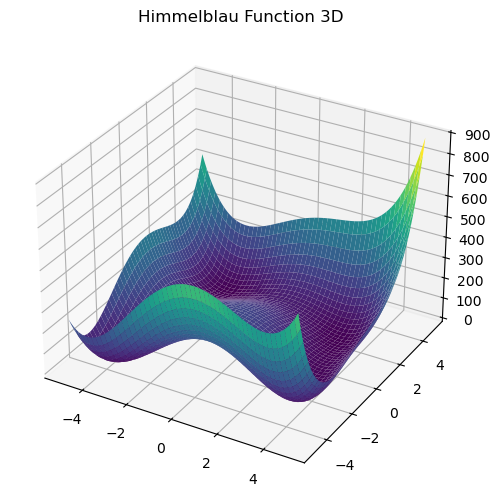

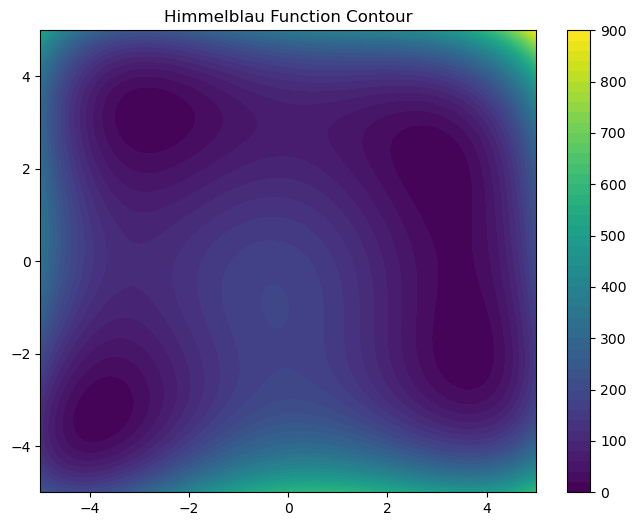

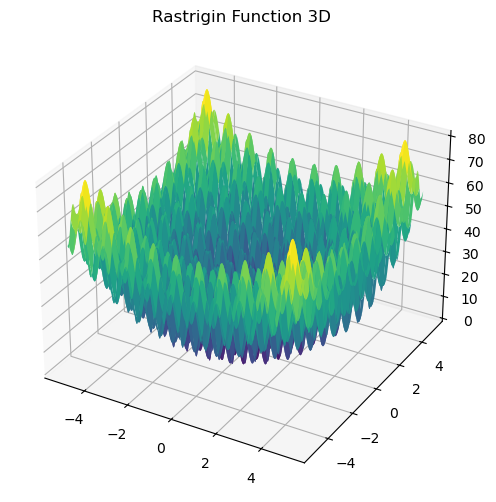

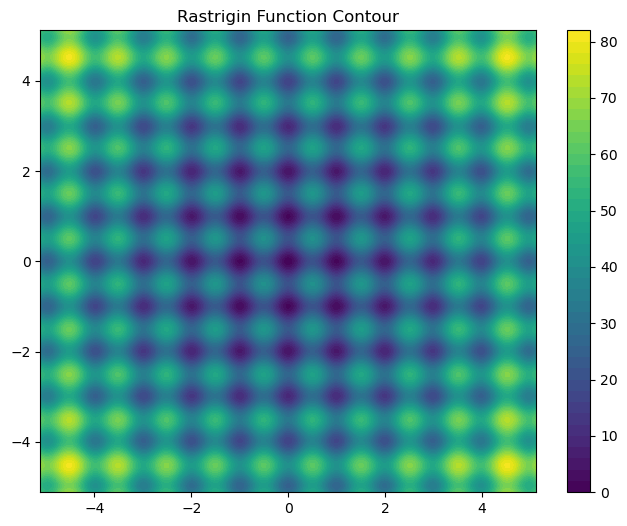

Himmelblau best (real-arithmetic): 0.41819520834827345


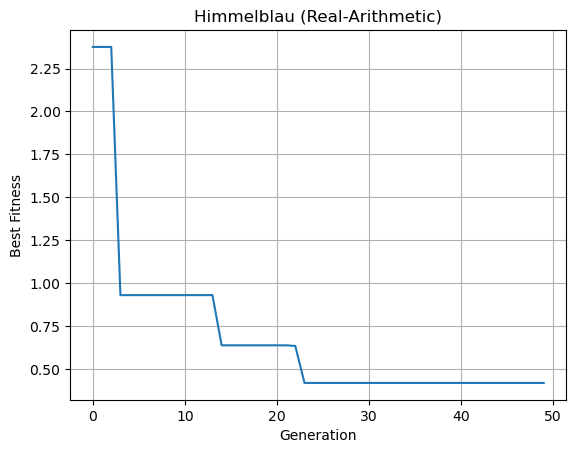

Rastrigin best (real-blx): 3.552713678800501e-15


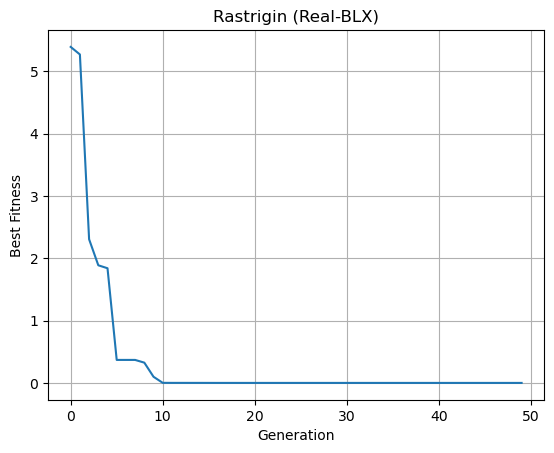

Himmelblau best (binary-1point): 0.0004968237116221525


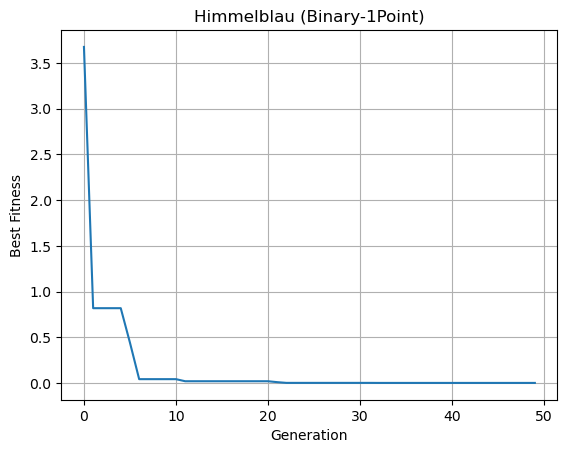

Rastrigin best (binary-2point): 2.289835971125882


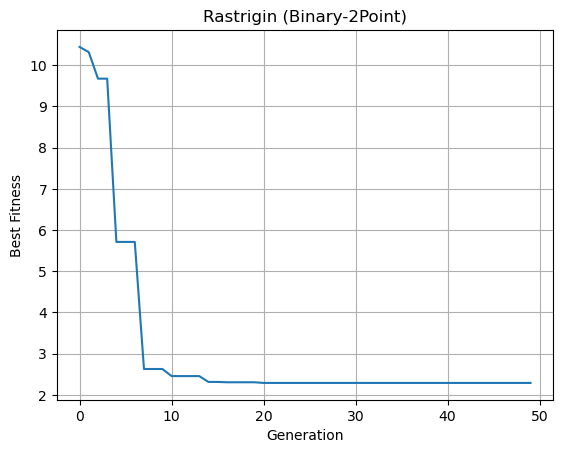

In [28]:
plot_function_3d(himmelblau, [[-5, 5], [-5, 5]], "Himmelblau Function 3D")
plot_function_contour(himmelblau, [[-5, 5], [-5, 5]], "Himmelblau Function Contour")
plot_function_3d(rastrigin, [[-5.12, 5.12], [-5.12, 5.12]], "Rastrigin Function 3D")
plot_function_contour(rastrigin, [[-5.12, 5.12], [-5.12, 5.12]], "Rastrigin Function Contour")

best, hist = genetic_algorithm(himmelblau, [[-5, 5], [-5, 5]], generations=50, real=True, crossover_method='arithmetic')
print("Himmelblau best (real-arithmetic):", best)
plot_evolution(hist, "Himmelblau (Real-Arithmetic)")

best, hist = genetic_algorithm(rastrigin, [[-5.12, 5.12], [-5.12, 5.12]], generations=50, real=True, crossover_method='blx')
print("Rastrigin best (real-blx):", best)
plot_evolution(hist, "Rastrigin (Real-BLX)")

best, hist = genetic_algorithm(himmelblau, [[-5, 5], [-5, 5]], generations=50, real=False, crossover_method='1point')
print("Himmelblau best (binary-1point):", best)
plot_evolution(hist, "Himmelblau (Binary-1Point)")

best, hist = genetic_algorithm(rastrigin, [[-5.12, 5.12], [-5.12, 5.12]], generations=50, real=False, crossover_method='2point')
print("Rastrigin best (binary-2point):", best)
plot_evolution(hist, "Rastrigin (Binary-2Point)")
